In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time
import IPython.display
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor, LongTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable as V
from torch.nn import functional as F
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
True


the number of data point(original signal): 44100


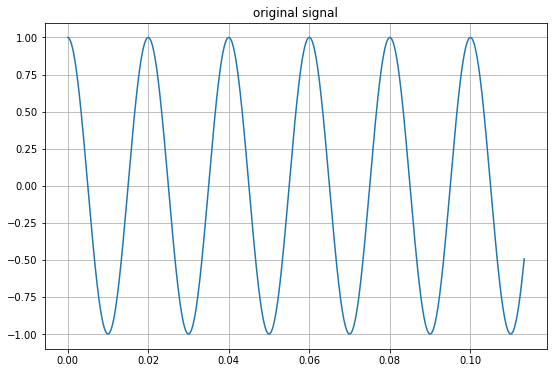

In [275]:
# 学習に使う人工データの生成
sampling_rate = 44100.0 # サンプリング周波数 [Hz] 
len_seconds = 1.0 # 時間長さ[s]
f_original = 50 # 原信号の周波数
t = np.arange(sampling_rate * len_seconds) / sampling_rate # サンプリング点の時間[s]
original_signal = np.cos(2 * np.pi *  f_original * t) # cosで原信号の生成
print('the number of data point(original signal):', len(original_signal))

# 原信号の描画
%matplotlib inline
plt.figure(figsize = (9, 6))
plt.plot(t[:5000], original_signal[:5000])
plt.title('original signal')
plt.grid()
plt.show()

# 原信号の再生
IPython.display.Audio(original_signal, rate=44100)

In [276]:
# ①FM変調
# f_carrierは搬送波の周波数[Hz]、MFDは最大周波数偏移[Hz]
# 参考文献 : http://yyatsuo.com/?p=1635
def freq_mod(original_signal, f_original, f_carrier, MFD):
    vm = np.sin(2*np.pi*f_carrier*t + (MFD/f_original)*np.sin(2*np.pi*f_original*t))
    return vm

the number of data point(frequency modulation signal): 44100


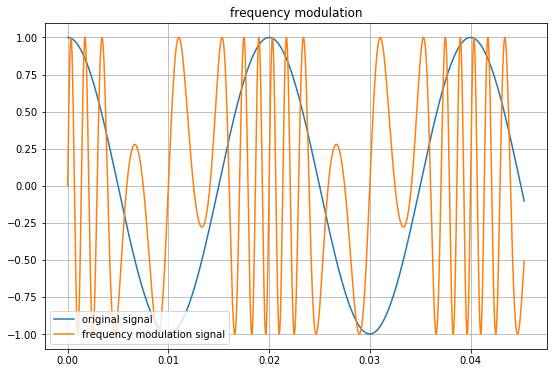

In [279]:
# 搬送波の周波数2000 [Hz], 最大周波数偏移 1000 [Hz] (一般的でない値？)
fm_signal = freq_mod(original_signal, f_original, 250, 500)
print('the number of data point(frequency modulation signal):', len(fm_signal))
plt.figure(figsize = (9, 6))
plt.plot(t[:2000], original_signal[:2000], label = 'original signal')
plt.plot(t[:2000], fm_signal[:2000], label = 'frequency modulation signal')
plt.legend(loc = 'lower left')
plt.title('frequency modulation')
plt.grid()
plt.show()

#FM変調信号の再生
IPython.display.Audio(fm_signal, rate=44100)

In [251]:
# ②AM変調
# f_carrierは搬送波の周波数 [Hz]
def amp_mod(original_signal, f_original, f_carrier):
    vm = np.cos(2*np.pi*f_carrier*t) + (1/2) * (np.cos(2*np.pi*(f_carrier-f_original)*t)+np.cos(2*np.pi*(f_carrier-f_original)*t))
    return vm

the number of data point(amplitude modulation signal): 44100


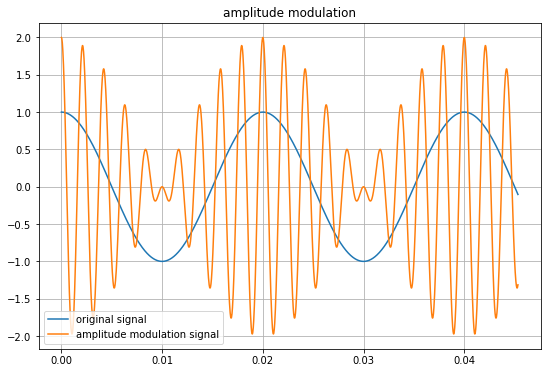

In [282]:
# 搬送波の周波数5000 [Hz] （一般的でない値？）
am_signal = amp_mod(original_signal, f_original, 500)
print('the number of data point(amplitude modulation signal):', len(am_signal))
plt.figure(figsize = (9, 6))
plt.plot(t[:2000], original_signal[:2000], label = 'original signal')
plt.plot(t[:2000], am_signal[:2000], label = 'amplitude modulation signal')
plt.legend(loc = 'lower left')
plt.title('amplitude modulation')
plt.grid()
plt.show()

# AM変調信号の再生
IPython.display.Audio(am_signal, rate=44100)

In [283]:
'''
# fm,amの組み合わせ
fm_am_signal = freq_mod(amp_mod(original_signal, f_original, 200), f_original, 500, 1000)
am_fm_signal = amp_mod(freq_mod(original_signal, f_original, 500, 5000), f_original, 1000)
plt.plot(fm_am_signal[:5000])
plt.show()
plt.plot(am_fm_signal[:2000])
plt.show()
'''

'\n# fm,amの組み合わせ\nfm_am_signal = freq_mod(amp_mod(original_signal, f_original, 200), f_original, 500, 1000)\nam_fm_signal = amp_mod(freq_mod(original_signal, f_original, 500, 5000), f_original, 1000)\nplt.plot(fm_am_signal[:5000])\nplt.show()\nplt.plot(am_fm_signal[:2000])\nplt.show()\n'

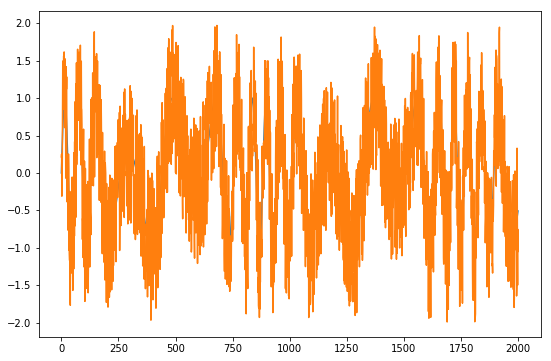

In [305]:
# ノイズの付与
def add_noise(signal, f_noise):
    return signal + np.random.uniform(-1, 1, len(signal)) * f_noise
fm_signal_noiseadded = add_noise(fm_signal, 1.0)
plt.figure(figsize = (9,6))
plt.plot(fm_signal[:2000])
plt.plot(fm_signal_noiseadded[:2000])
plt.show()

In [306]:
# 信号の量子化（符号あり16bit）
def quantize_16bit(signal):
    signal = signal - np.mean(signal)
    quantized_16bit_signal = (signal / np.max(np.abs(signal))*(2**15)).astype(np.int16)
    return quantized_16bit_signal

In [307]:
# 信号の量子化（符号なし8bit）
def quantize_8bit(signal):
    signal = signal - np.mean(signal)
    signal = signal / np.max(np.abs(signal))
    signal = np.round(signal * (2 ** 7 - 1))
    signal = (signal + 127).astype(np.uint8)
    return signal

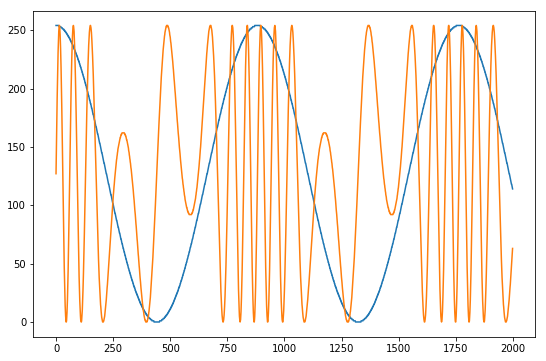

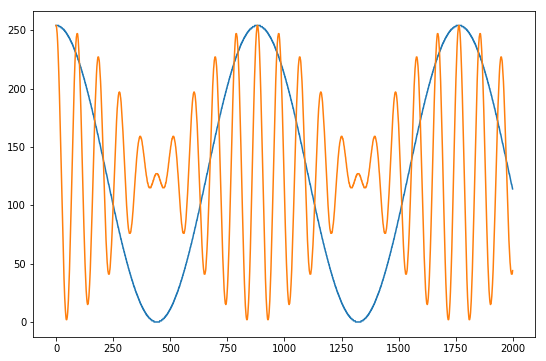

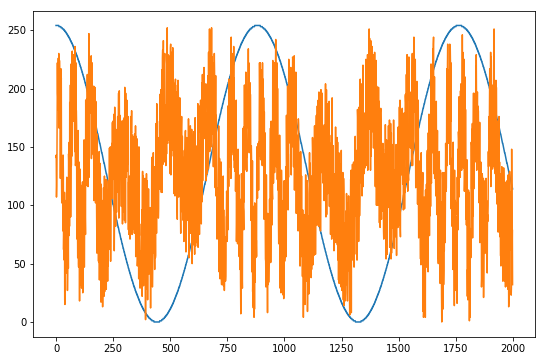

In [308]:
# 取り敢えず0 ～ 255の分類問題にするために量子化（なんか0 ～　254になってしまっている？）
# 原論文では符号あり16bitに量子化された音声データをμ-lawアルゴリズムで8ビット化しているようだが、取り敢えず今回は直接符号なし8ビットに
original_signal_quantized_8bit = quantize_8bit(original_signal)
fm_signal_quantized_8bit = quantize_8bit(fm_signal)
am_signal_quantized_8bit = quantize_8bit(am_signal)
fm_signal_noiseadded_quantized_8bit = quantize_8bit(fm_signal_noiseadded)
plt.figure(figsize = (9, 6))
plt.plot(original_signal_quantized_8bit[:2000])
plt.plot(fm_signal_quantized_8bit[:2000])
plt.show()
plt.figure(figsize = (9, 6))
plt.plot(original_signal_quantized_8bit[:2000])
plt.plot(am_signal_quantized_8bit[:2000])
plt.show()
plt.figure(figsize = (9, 6))
plt.plot(original_signal_quantized_8bit[:2000])
plt.plot(fm_signal_noiseadded_quantized_8bit[:2000])
plt.show()

In [324]:
# 受容野の広さと信号を受け取り、それに応じたデータセットを作成
# ”受容野の広さ”数分の信号のクラスを入力データ、次の瞬間の信号1つのクラスを出力データとする
N_reception = 256
def make_dataset(signal, n_reception):
    X = []
    Y = []
    for i in range(len(signal) - n_reception):
        X.append(signal[i:i+n_reception])
        Y.append(signal[i+n_reception])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [325]:
# FM変調信号学習、バリデーションのためのデータセットの準備
'''
X_fm, Y_fm = make_dataset(fm_signal_quantized_8bit, N_reception)
X_fm_train, X_fm_valid, Y_fm_train, Y_fm_valid = train_test_split(X_fm, Y_fm, test_size = 0.2)
ds_fm_train = TensorDataset(Tensor(X_fm_train), LongTensor(Y_fm_train))
ds_fm_valid = TensorDataset(Tensor(X_fm_valid), LongTensor(Y_fm_valid))
fm_train_loader = DataLoader(ds_fm_train, batch_size = 64, shuffle = True)
fm_valid_loader = DataLoader(ds_fm_valid, batch_size = 64, shuffle = False)
'''
X_fm, Y_fm = make_dataset(fm_signal_noiseadded_quantized_8bit, N_reception)
X_fm_train, X_fm_valid, Y_fm_train, Y_fm_valid = train_test_split(X_fm, Y_fm, test_size = 0.2)
ds_fm_train = TensorDataset(Tensor(X_fm_train), LongTensor(Y_fm_train))
ds_fm_valid = TensorDataset(Tensor(X_fm_valid), LongTensor(Y_fm_valid))
fm_train_loader = DataLoader(ds_fm_train, batch_size = 64, shuffle = True)
fm_valid_loader = DataLoader(ds_fm_valid, batch_size = 64, shuffle = False)

In [326]:
# AM変調信号学習、バリデーションのためのデータセットの準備
X_am, Y_am = make_dataset(am_signal_quantized_8bit, N_reception)
X_am_train, X_am_valid, Y_am_train, Y_am_valid = train_test_split(X_am, Y_am, test_size = 0.2)
ds_am_train = TensorDataset(Tensor(X_am_train), LongTensor(Y_am_train))
ds_am_valid = TensorDataset(Tensor(X_am_valid), LongTensor(Y_am_valid))
am_train_loader = DataLoader(ds_am_train, batch_size = 64, shuffle = True)
am_valid_loader = DataLoader(ds_am_valid, batch_size = 64, shuffle = False)

In [327]:
# 単なる多層パーセプトロン
class MLP(nn.Module):
    def __init__(self, n_reception, hidden_size, n_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_reception, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        return out

In [328]:
# CNN

In [329]:
# dilated convolution
class Dilated_Conv1D(nn.Module):
    def __init__(self, n_reception, n_classes):
        super(Dilated_Conv1D, self).__init__()
        self.cv1 = nn.Conv1D()

In [330]:
# ロス関数、オプティマイザ
net = MLP(N_reception, 128, 256)
params = list(net.parameters())
N_params = 0
for p in params:
    N_params += len(p)
print('the number of parameters:', N_params)
if torch.cuda.is_available():
    net.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

the number of parameters: 1024


In [331]:
def train(train_loader):
    net.train()
    running_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = V(inputs)
        targets = V(targets)
        
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        
        preds = net(inputs)
        loss = loss_fn(preds, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / (i + 1)
    
    return train_loss

In [332]:
def valid(valid_loader):
    net.eval()
    running_loss = 0
    for i, (inputs, targets) in enumerate(valid_loader):
        with torch.no_grad():
            inputs = V(inputs)
            targets = V(targets)
            
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
        
            preds = net(inputs)
            loss = loss_fn(preds, targets)
        
        running_loss += loss.data.item()
    
    valid_loss = running_loss / (i + 1)
    
    return valid_loss

In [333]:
# fm変調の学習
losses = []
val_losses = []
n_epoch = 20
start = time.time()
for epoch in range(n_epoch):
    loss = train(fm_train_loader)
    val_loss = valid(fm_valid_loader)
    print('epoch[%d/%d] loss:%1.4f val_loss:%1.4f elasped_time:%4.4f' % (epoch+1, n_epoch, loss, val_loss, time.time() - start))
    
    losses.append(loss)
    val_losses.append(val_loss)
print('elasped_time:%2.4f' % (time.time() - start))

epoch[1/20] loss:5.8210 val_loss:5.4110 elasped_time:1.0813
epoch[2/20] loss:5.3495 val_loss:5.2783 elasped_time:2.1391
epoch[3/20] loss:5.1860 val_loss:5.1548 elasped_time:3.0877
epoch[4/20] loss:5.1187 val_loss:5.1010 elasped_time:4.1118
epoch[5/20] loss:5.0955 val_loss:5.0896 elasped_time:5.1853
epoch[6/20] loss:5.0790 val_loss:5.0824 elasped_time:6.2739
epoch[7/20] loss:5.0695 val_loss:5.0791 elasped_time:7.3627
epoch[8/20] loss:5.0609 val_loss:5.0836 elasped_time:8.4304
epoch[9/20] loss:5.0580 val_loss:5.0626 elasped_time:9.4935
epoch[10/20] loss:5.0578 val_loss:5.0642 elasped_time:10.5299
epoch[11/20] loss:5.0503 val_loss:5.0645 elasped_time:11.5608
epoch[12/20] loss:5.0444 val_loss:5.0626 elasped_time:12.6207
epoch[13/20] loss:5.0433 val_loss:5.0766 elasped_time:13.6921
epoch[14/20] loss:5.0413 val_loss:5.0618 elasped_time:14.7624
epoch[15/20] loss:5.0345 val_loss:5.0673 elasped_time:15.8625
epoch[16/20] loss:5.0319 val_loss:5.0589 elasped_time:16.9375
epoch[17/20] loss:5.0319 v

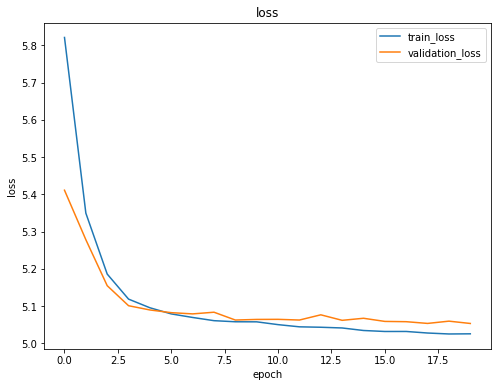

In [334]:
# fm変調のロス表示
plt.figure(figsize = (8,6))
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses, label = 'train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.legend()
plt.show()

In [335]:
# fm変調のテスト（未来の波形予測）
s_point = 20 # 予測を始めるための初期データの開始地点
n_predict_point = 5000 # 予測するデータ点の数
data_first = fm_signal_quantized_8bit[s_point : s_point + N_reception]
data_for_pred = np.copy(data_first)
predicted_data = []
for i in range(n_predict_point):
    with torch.no_grad():
        inputs = V(Tensor(data_for_pred))
        if torch.cuda.is_available():
            inputs = inputs.cuda()
        outputs = net(inputs)
    _, pred = torch.max(outputs, 0) 
    pred = pred.item()
    predicted_data.append(pred)
    data_for_pred = np.append(data_for_pred, pred)
    data_for_pred = np.delete(data_for_pred, 0)
predicted_data = np.concatenate([data_first, predicted_data])

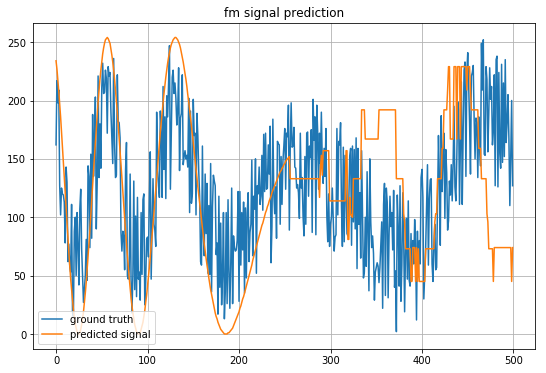

In [337]:
# fm変調のグラフ描画
s_plot = 0 # この点からプロット開始
plt.figure(figsize = (9, 6))
plt.plot(fm_signal_noiseadded_quantized_8bit[s_plot + s_point : s_plot + s_point + 500], label = 'ground truth')
plt.plot(predicted_data[s_plot:s_plot + 500], label = 'predicted signal')
plt.legend(loc = 'lower left')
plt.title('fm signal prediction')
plt.grid()
plt.show()

In [178]:
# ロス関数、オプティマイザ
net = MLP(N_reception, 128, 256)
params = list(net.parameters())
N_params = 0
for p in params:
    N_params += len(p)
print('the number of parameters:', N_params)
if torch.cuda.is_available():
    net.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

the number of parameters: 1024


In [179]:
# am変調の学習
losses = []
val_losses = []
n_epoch = 20
start = time.time()
for epoch in range(n_epoch):
    loss = train(am_train_loader)
    val_loss = valid(am_valid_loader)
    print('epoch[%d/%d] loss:%1.4f val_loss:%1.4f elasped_time:%4.4f' % (epoch+1, n_epoch, loss, val_loss, time.time() - start))
    
    losses.append(loss)
    val_losses.append(val_loss)
print('elasped_time:%2.4f' % (time.time() - start))

epoch[1/20] loss:3.1647 val_loss:1.2917 elasped_time:0.9692
epoch[2/20] loss:0.8958 val_loss:0.6544 elasped_time:1.9621
epoch[3/20] loss:0.4370 val_loss:0.2743 elasped_time:2.9214
epoch[4/20] loss:0.2180 val_loss:0.1169 elasped_time:3.9109
epoch[5/20] loss:0.1096 val_loss:0.0708 elasped_time:4.8562
epoch[6/20] loss:0.0625 val_loss:0.6247 elasped_time:5.8205
epoch[7/20] loss:0.1944 val_loss:0.0145 elasped_time:6.7874
epoch[8/20] loss:0.0114 val_loss:0.0098 elasped_time:7.7584
epoch[9/20] loss:0.2642 val_loss:0.0236 elasped_time:8.7294
epoch[10/20] loss:0.0118 val_loss:0.0082 elasped_time:9.6460
epoch[11/20] loss:0.0066 val_loss:0.0052 elasped_time:10.5919
epoch[12/20] loss:0.0045 val_loss:0.0037 elasped_time:11.5726
epoch[13/20] loss:0.0033 val_loss:0.0028 elasped_time:12.5565
epoch[14/20] loss:0.0024 val_loss:0.0021 elasped_time:13.5509
epoch[15/20] loss:0.0018 val_loss:0.0015 elasped_time:14.5013
epoch[16/20] loss:0.0013 val_loss:0.0011 elasped_time:15.4248
epoch[17/20] loss:0.0010 va

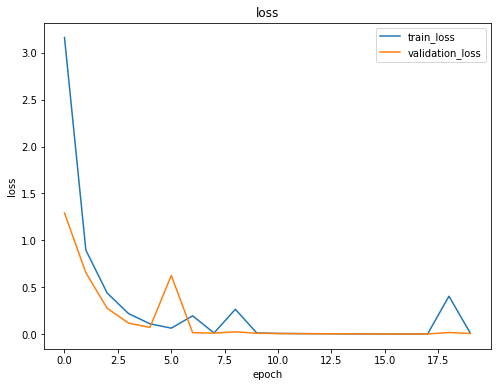

In [180]:
# am変調のロス表示
plt.figure(figsize = (8,6))
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses, label = 'train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.legend()
plt.show()

In [181]:
# am変調のテスト（未来の波形予測）
s_point = 20 # 予測を始めるための初期データの開始地点
n_predict_point = 50000 # 予測するデータ点の数
data_first = am_signal_quantized_8bit[s_point : s_point + N_reception]
data_for_pred = np.copy(data_first)
predicted_data = []
for i in range(n_predict_point):
    with torch.no_grad():
        inputs = V(Tensor(data_for_pred))
        if torch.cuda.is_available():
            inputs = inputs.cuda()
        outputs = net(inputs)
    _, pred = torch.max(outputs, 0) 
    pred = pred.item()
    predicted_data.append(pred)
    data_for_pred = np.append(data_for_pred, pred)
    data_for_pred = np.delete(data_for_pred, 0)
predicted_data = np.concatenate([data_first, predicted_data])

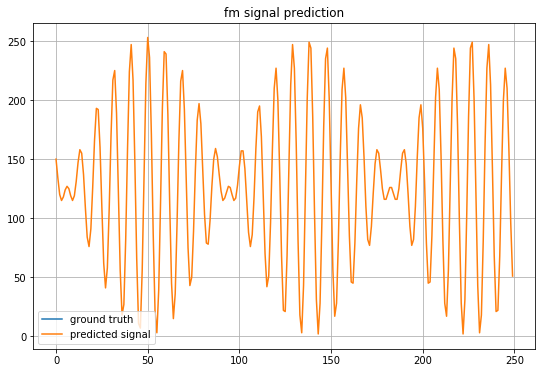

In [182]:
# fm変調のグラフ描画
s_plot = 45000 # この点からプロット開始
plt.figure(figsize = (9, 6))
plt.plot(am_signal_quantized_8bit[s_plot + s_point : s_plot + s_point + 250], label = 'ground truth')
plt.plot(predicted_data[s_plot:s_plot + 250], label = 'predicted signal')
plt.legend(loc = 'lower left')
plt.title('fm signal prediction')
plt.grid()
plt.show()